## Fetch data


In [4]:
from sklearn.datasets import fetch_openml


mnist = fetch_openml("mnist_784", version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [5]:
X, y = mnist["data"], mnist["target"]


In [6]:
X.shape

(70000, 784)

In [7]:
y.shape

(70000,)

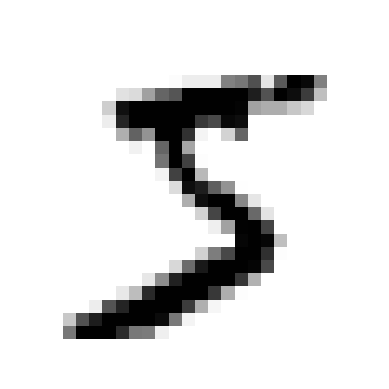

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [9]:
y[0]

'5'

In [10]:
import numpy as np

y = y.astype(np.uint8)

In [11]:
X_train, X_test, y_train, y_test = X[:6000], X[6000:], y[:6000], y[6000:]

## Train a binary Classfier


In [12]:
y_train_5 = y_train == 5
y_test_5 = y_test == 5

In [13]:
from sklearn.linear_model import SGDClassifier


sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)


,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [14]:
sgd_clf.predict([some_digit])

array([ True])

## Cross validation


In [15]:
from sklearn import clone
from sklearn.model_selection import StratifiedKFold

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9615
0.962
0.963


In [16]:
from sklearn.model_selection import cross_val_score


cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.962 , 0.956 , 0.9665])

In [17]:
from sklearn.base import BaseEstimator


class Never5Classfier(BaseEstimator):
    def fit(self, X, y=None):
        pass

    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [18]:
never_5_clf = Never5Classfier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91 , 0.915, 0.918])

In [19]:
from sklearn.calibration import cross_val_predict


y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [20]:
from sklearn.metrics import confusion_matrix


confusion_matrix(y_train_5, y_train_pred)

array([[5375,  111],
       [ 120,  394]])

## Precision and Recall


In [21]:
from sklearn.metrics import precision_score

precision_score(y_train_5, y_train_pred)

0.7801980198019802

In [22]:
from sklearn.metrics import recall_score


recall_score(y_train_5, y_train_pred)

0.7665369649805448

In [23]:
from sklearn.metrics import f1_score


f1_score(y_train_5, y_train_pred)

0.7733071638861629

In [24]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([38042.34312442])

In [25]:
threshold = 0
y_some_digit_pred = y_scores > threshold
y_some_digit_pred

array([ True])

In [26]:
threshold = 80000
y_some_digit_pred = y_scores > threshold
y_some_digit_pred

array([False])

In [27]:
y_scores = cross_val_predict(
    sgd_clf, X_train, y_train_5, cv=3, method="decision_function"
)

In [28]:
from sklearn.metrics import precision_recall_curve


precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

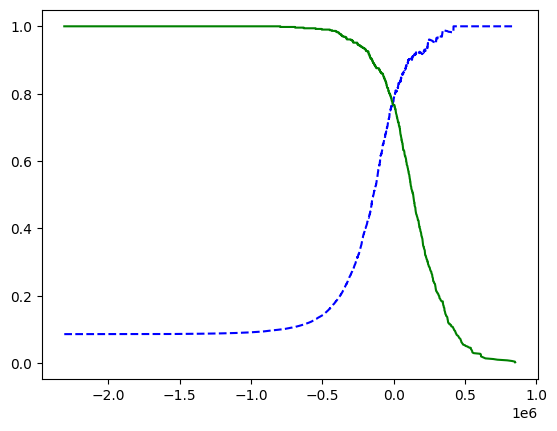

In [29]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")


plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [30]:
thresh_90_precision = thresholds[np.argmax(precisions >= 0.9)]

y_train_pred_90 = y_scores >= thresh_90_precision

In [31]:
precision_score(y_train_5, y_train_pred_90)

0.9012345679012346

In [32]:
recall_score(y_train_5, y_train_pred_90)

0.5680933852140078

## ROC curve (receiver operating characteristic)


In [33]:
from sklearn.metrics import roc_curve


fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)


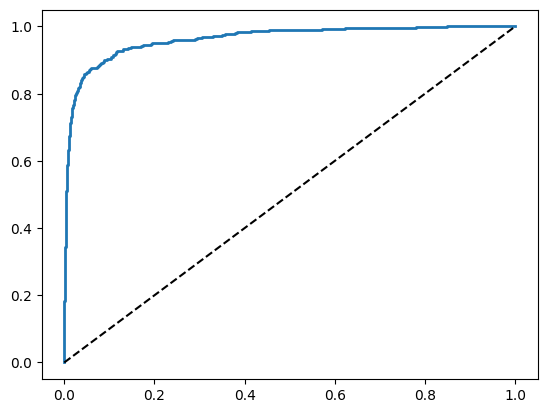

In [34]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")


plot_roc_curve(fpr, tpr)
plt.show()

In [35]:
from sklearn.metrics import roc_auc_score


roc_auc_score(y_train_5, y_scores)


0.9641599203348885

In [36]:
from sklearn.ensemble import RandomForestClassifier


forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(
    forest_clf, X_train, y_train_5, cv=3, method="predict_proba"
)

In [37]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

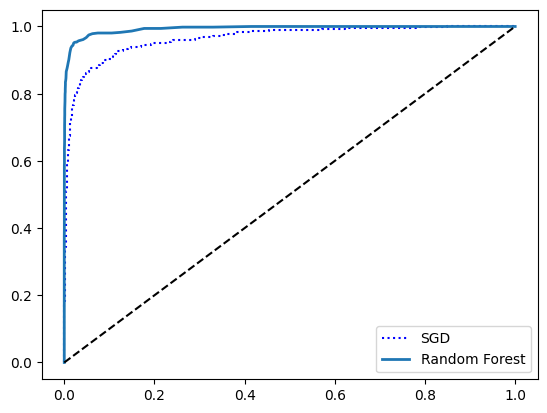

In [38]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [39]:
roc_auc_score(y_train_5, y_scores_forest)

0.9936162229715256

## Multiclass classification


In [40]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])  # 10 binary classifiers indeed

array([5], dtype=uint8)

In [41]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-735711.69660953, -857058.38635209, -281086.00104909,
           8289.73273042, -616793.26669143,   29040.2961313 ,
        -492305.02284074, -834395.17091855, -318385.3774766 ,
        -363474.38706356]])

In [42]:
from sklearn.multiclass import OneVsOneClassifier


ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [43]:
len(ovo_clf.estimators_)

45

In [44]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=uint8)

In [45]:
forest_clf.predict_proba([some_digit])

array([[0.01, 0.03, 0.01, 0.11, 0.01, 0.8 , 0.01, 0.  , 0.01, 0.01]])

In [46]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.8565, 0.8715, 0.8635])

In [47]:
from sklearn.discriminant_analysis import StandardScaler


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8705, 0.8985, 0.8925])

In [48]:
some_digit

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,  18,  18,
       126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,  30,  36,  94, 154, 17

In [49]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[572,   0,   1,   2,   1,   9,   3,   1,   3,   0],
       [  0, 637,   6,   3,   1,   5,   0,   1,  16,   2],
       [ 10,  12, 493,  11,  10,   4,  10,   9,  20,   2],
       [  3,   5,  21, 514,   1,  35,   1,   7,  11,  10],
       [  3,   2,   7,   0, 556,   2,  10,   8,   9,  26],
       [  5,   6,   5,  24,  14, 411,  10,   1,  25,  13],
       [  4,   4,   6,   0,   5,   6, 577,   1,   5,   0],
       [  3,   4,   7,   2,   9,   0,   1, 577,   3,  45],
       [  2,  19,  13,  16,   4,  10,   6,   3, 464,  14],
       [  7,   4,   5,   7,  15,   3,   0,  27,  11, 522]])

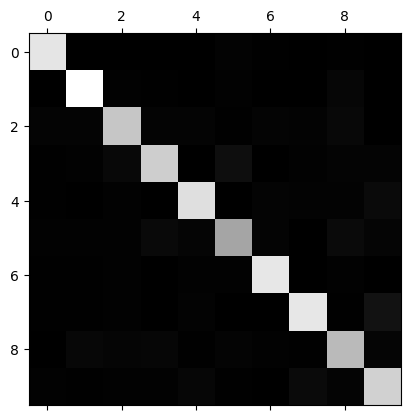

In [50]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

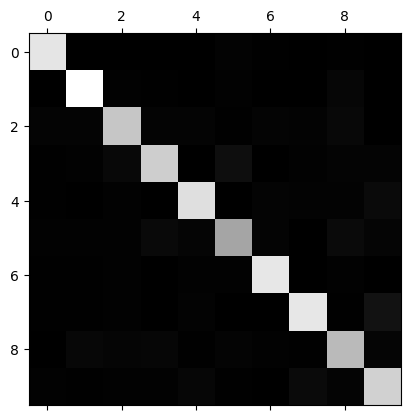

In [51]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [52]:
row_sums = conf_mx.sum(axis=1, keepdims=True)  # axis=1 for by line
norm_conf_mx = conf_mx / row_sums
print(row_sums.shape)
print(conf_mx.shape)

(10, 1)
(10, 10)


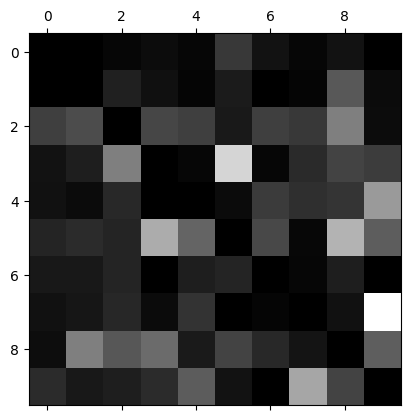

In [53]:
np.fill_diagonal(norm_conf_mx, 0)
# 越亮代表比例越大,如果不把主对角线(main diagonal)填上0,其他的亮度将不够亮,导致看不清
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

In [54]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate(
        [instances, np.zeros((n_empty, size * size))], axis=0
    )

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(
        n_rows * size, images_per_row * size
    )
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap=mpl.cm.binary, **options)
    plt.axis("off")

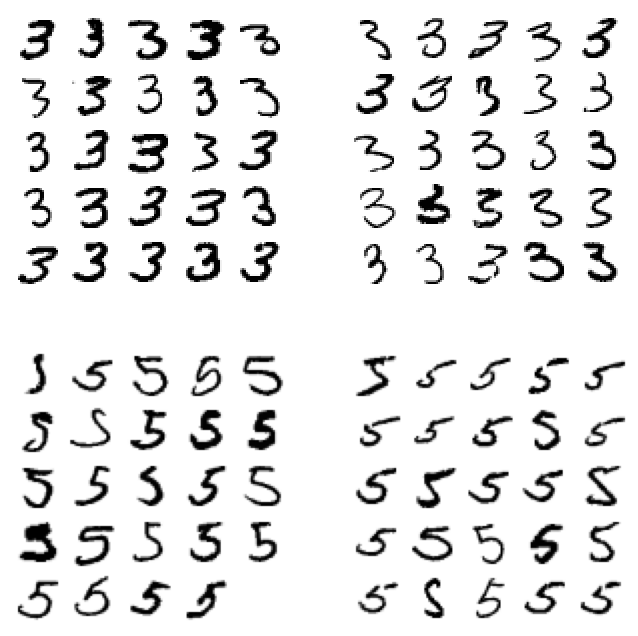

In [55]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
plt.figure(figsize=(8, 8))
plt.subplot(221)
plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222)
plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223)
plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224)
plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## Multilabel classification


In [56]:
from sklearn.neighbors import KNeighborsClassifier


y_train_large = y_train >= 7
y_train_odd = y_train % 2 == 1
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [57]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [58]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")
# macro即标签同等重要,如何要带权重,使用weighted

0.9500922726736858

## Multioutput classification


In [62]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

In [63]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=mpl.cm.binary, interpolation="nearest")
    plt.axis("off")

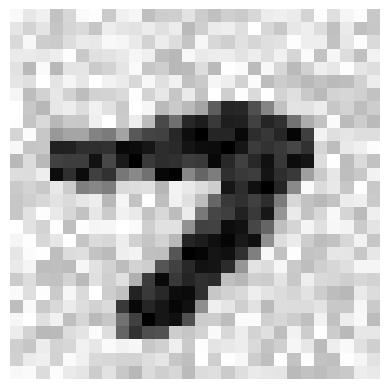

In [72]:
plot_digit(X_test_mod[15])


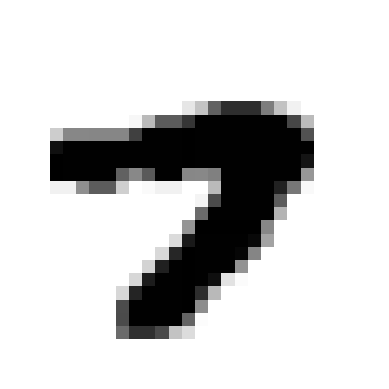

In [71]:
plot_digit(y_test_mod[15])

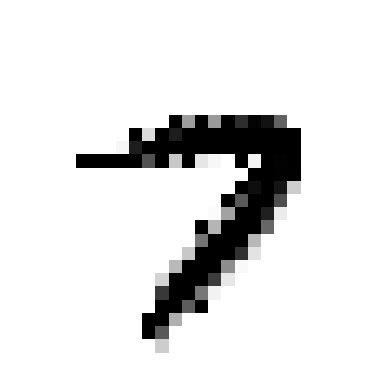

In [73]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[15]])
plot_digit(clean_digit)

In [86]:
from sklearn.model_selection import RandomizedSearchCV

knn_clf = KNeighborsClassifier()

param_grid = {
    "n_neighbors": range(5, 15, 2),
    "weights": ["uniform", "distance"],
}

random_search = RandomizedSearchCV(
    knn_clf, param_grid, n_iter=10, cv=5, scoring="accuracy"
)

random_search.fit(X_train, y_train)

,estimator,KNeighborsClassifier()
,param_distributions,"{'n_neighbors': range(5, 15, 2), 'weights': ['uniform', 'distance']}"
,n_iter,10
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [87]:
random_search.best_params_

{'weights': 'distance', 'n_neighbors': 5}

In [88]:
from sklearn.metrics import accuracy_score

model = random_search.best_estimator_

y_test_pred = model.predict(X_test)
accuracy_score(y_test, y_test_pred)

0.935578125

In [ ]:
from scipy.ndimage import shift

shift(some_digit, (784,))


(784,)

In [97]:
X_train_expanded_list, y_train_expanded_list = X_train.tolist(), y_train.tolist()

dirs = [(-1, 0), (1, 0), (0, -1), (0, 1)]
for dir in dirs:
    for i in range(0, len(X_train)):
        reshaped = X_train[i].reshape(28, 28)
        shifted = shift(reshaped, dir)
        X_train_expanded_list.append(
            shifted.reshape(
                784,
            )
        )
        y_train_expanded_list.append(y_train[i])

In [ ]:
X_train_expanded = np.array(X_train_expanded_list)
y_train_expanded = np.array(y_train_expanded_list)
shuffled_indices = np.random.permutation(len(X_train_expanded))
X_train_final = X_train_expanded[shuffled_indices]
y_train_final = y_train_expanded[shuffled_indices]

In [100]:
model.fit(X_train_final, y_train_final)

,n_neighbors,5
,weights,'distance'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [101]:
y_test_pred = model.predict(X_test)
accuracy_score(y_test, y_test_pred)

0.94965625